In [34]:
# compute the distribution of class labels

import pandas as pd

data = pd.read_csv("../../data/01-modified-data/New_students_adaptability.csv")

class_distribution = data['Adaptivity Level'].value_counts(normalize=True) * 100

formatted_distribution = class_distribution.apply(lambda x: f"{x:.2f}%")

print(formatted_distribution)



2    51.87%
1    39.83%
0     8.30%
Name: Adaptivity Level, dtype: object


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# baseline decision tree model
X = data.drop('Adaptivity Level', axis=1)
y = data['Adaptivity Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


tree = DecisionTreeClassifier(random_state=20)
tree.fit(X_train_scaled, y_train)

y_pred = tree.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()
report_df_rounded = report_df.round(2)

accuracy, report_df_rounded

(0.7800829875518672,
               precision  recall  f1-score  support
 0                  0.75    0.86      0.80    21.00
 1                  0.74    0.80      0.77    96.00
 2                  0.82    0.75      0.78   124.00
 accuracy           0.78    0.78      0.78     0.78
 macro avg          0.77    0.80      0.78   241.00
 weighted avg       0.78    0.78      0.78   241.00)

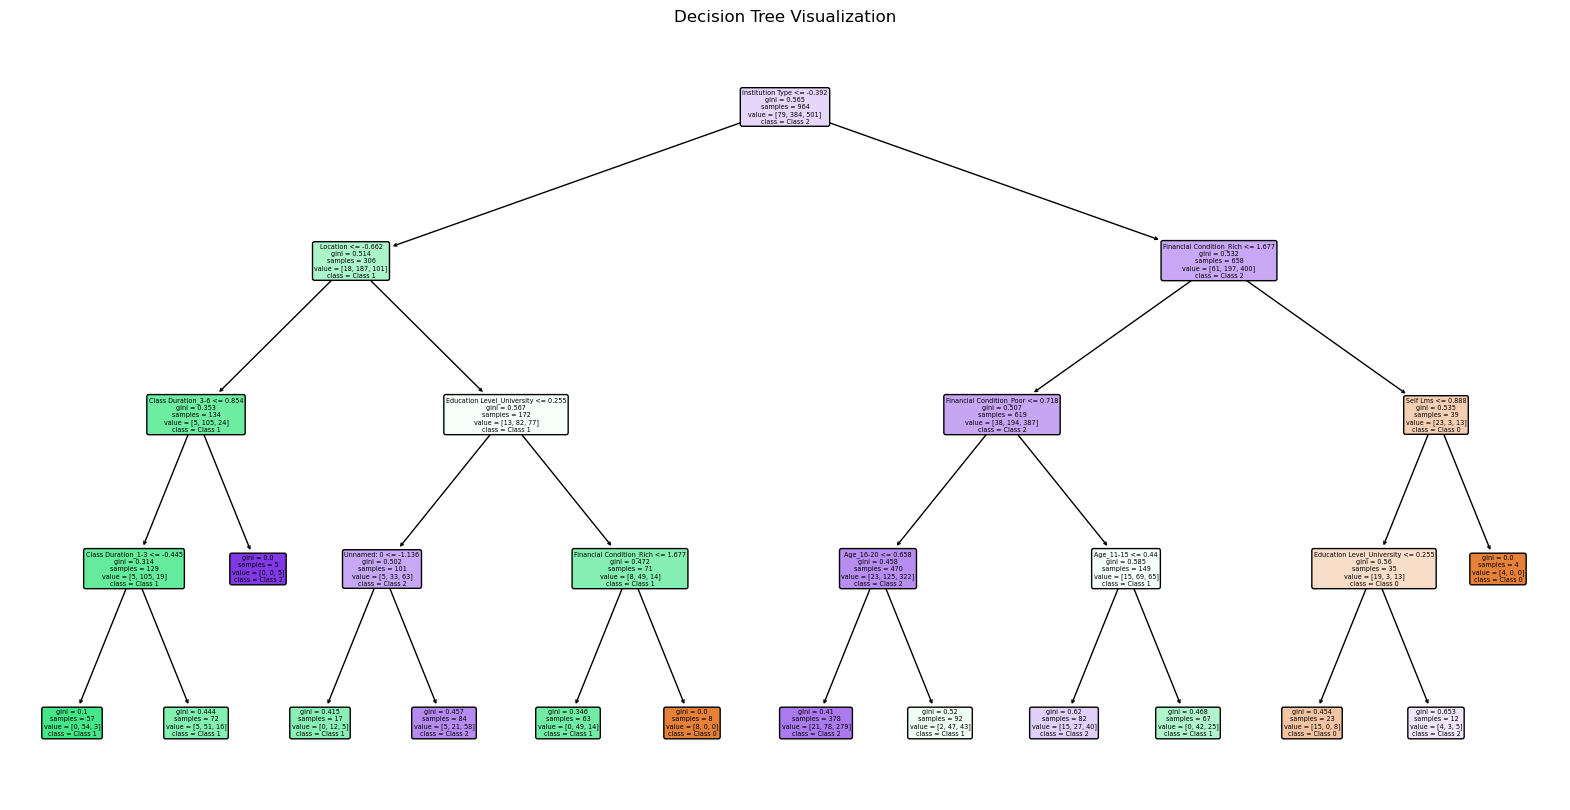

In [36]:
# Visualize the tree

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

tree_plot = DecisionTreeClassifier(random_state=20, max_depth=4)
tree_plot.fit(X_train_scaled, y_train)


plt.figure(figsize=(20, 10))
plot_tree(tree_plot, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1', 'Class 2'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

In [37]:
# random forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=30)
random_forest.fit(X_train_scaled, y_train)

y_pred_rf = random_forest.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

report_rf = pd.DataFrame(report_rf).transpose()
report_df_rounded_rf = report_rf.round(2)

accuracy_rf, report_df_rounded_rf

(0.8796680497925311,
               precision  recall  f1-score  support
 0                  0.84    0.76      0.80    21.00
 1                  0.87    0.91      0.89    96.00
 2                  0.89    0.88      0.89   124.00
 accuracy           0.88    0.88      0.88     0.88
 macro avg          0.87    0.85      0.86   241.00
 weighted avg       0.88    0.88      0.88   241.00)

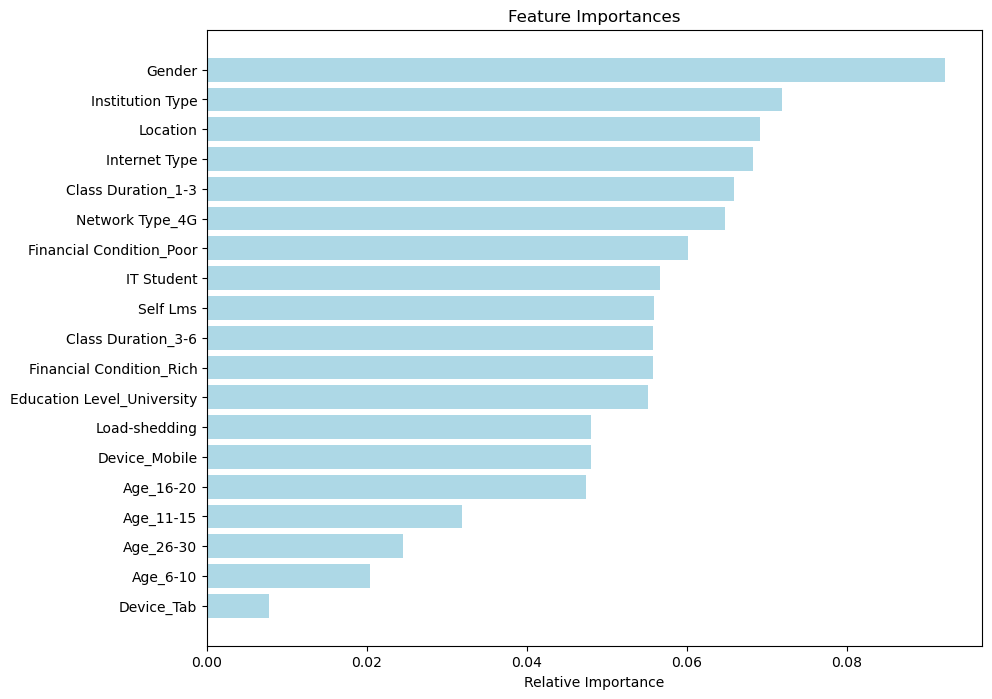

In [33]:
# random forest visualization

import numpy as np
feature_impo = random_forest.feature_importances_

# Creating a bar plot for feature importances
features = X.columns
indices = np.argsort(feature_impo)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_impo[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [38]:
# Hyperparameter tuning for random forest

from sklearn.model_selection import RandomizedSearchCV

param_sets = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True, False]
}


# Randomized search on hyper parameters
random_search = RandomizedSearchCV(
    estimator=random_forest, 
    param_distributions=param_sets,
    n_iter=10, 
    cv=3, 
    verbose=2, 
    random_state=30, 
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

(best_params, best_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100; to

({'n_estimators': 200,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_depth': 50,
  'bootstrap': False},
 0.8153254258496031)

In [39]:
# final results

tuned_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=50,
    bootstrap=False,
    random_state=30
)

tuned_rf.fit(X_train_scaled, y_train)
y_pred_tuned = tuned_rf.predict(X_test_scaled)

report_dict_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

report_df_tuned = pd.DataFrame(report_dict_tuned).transpose()
report_df_rounded_tuned = report_df_tuned.round(2)

report_df_rounded_tuned

,precision,recall,f1-score,support
0,0.89,0.81,0.85,21.00
1,0.88,0.89,0.88,96.00
2,0.89,0.90,0.89,124.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.89,0.86,0.87,241.00
weighted avg,0.88,0.88,0.88,241.00
